In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_csv('D:/Data/apartment/cleaned_apartment.csv')

In [3]:
df.drop(['unit_name','link-href','apt_name','apt_id','grocery_store'],axis=1,inplace=True,errors='ignore')

In [4]:
df_clean = pd.get_dummies(df,columns=['region'])

In [5]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_clean['furnished'] = encoder.fit_transform(df.furnished)

# Modelling

In [6]:
X = df_clean[df_clean.area>25].drop('annual_price',axis=1)
y = df_clean[df_clean.area>25].annual_price

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# Without hyperparameter

In [7]:
def evaluation(model):
    model.fit(X_train,y_train)
    print('R2 Score :', r2_score(y_test, model.predict(X_test)))
    print('MS Error :', mean_squared_error(y_test, model.predict(X_test)))
    print('RMS Error:', np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    

In [8]:
# XGB
xgb = XGBRegressor()

In [9]:
evaluation(xgb)

R2 Score : 0.8540656736266639
MS Error : 2498709500492085.5
RMS Error: 49987093.3391019


In [10]:
# Catboost
catboost = CatBoostRegressor()
evaluation(catboost)

Learning rate set to 0.047638
0:	learn: 120059841.5913397	total: 164ms	remaining: 2m 43s
1:	learn: 116481833.1268068	total: 170ms	remaining: 1m 24s
2:	learn: 112889669.2882160	total: 198ms	remaining: 1m 5s
3:	learn: 109288137.7763362	total: 203ms	remaining: 50.6s
4:	learn: 105917724.7641315	total: 212ms	remaining: 42.1s
5:	learn: 102694615.6261196	total: 214ms	remaining: 35.5s
6:	learn: 99762151.9303472	total: 217ms	remaining: 30.8s
7:	learn: 96727606.5382590	total: 220ms	remaining: 27.3s
8:	learn: 93978374.2459026	total: 222ms	remaining: 24.5s
9:	learn: 91416479.9072893	total: 225ms	remaining: 22.2s
10:	learn: 89182114.8233286	total: 227ms	remaining: 20.4s
11:	learn: 86902088.3998841	total: 229ms	remaining: 18.9s
12:	learn: 84755012.8825734	total: 233ms	remaining: 17.7s
13:	learn: 82674739.6014451	total: 235ms	remaining: 16.6s
14:	learn: 80799930.5474612	total: 237ms	remaining: 15.6s
15:	learn: 79005349.4356712	total: 240ms	remaining: 14.7s
16:	learn: 77406541.0518169	total: 243ms	rem

In [11]:
# lgbm
lgb = LGBMRegressor()
evaluation(lgb)

R2 Score : 0.8666000388973344
MS Error : 2284094211801618.0
RMS Error: 47792198.23152748


Without set any parameter for each machine learning, Catboost model has the biggest r2_score and the lowest error

# HyperparameterTuning

## 1. XGB

In [12]:
params1 = {'learning_rate':[x for x in np.arange(0.05,0.5,0.05)],
          'n_estimators' :[j for j in range(80,100)],
          'max_depth':[a for a in range(1,8)],
          'min_child_weight':[b for b in range(1,9)],    
          'gamma': range(1, 9),
          "reg_alpha": [m for m in np.arange(0.1, 0.7,0.09)],
           'scale_pos_weight':[13.92,14]
         }
params2 = {
        'max_depth': (4, 6),
        'gamma': (0.0001, 0.005),
        'min_child_weight': (1, 2),
        'max_delta_step': (0, 1),
        'subsample': (0.2, 0.4),
        'colsample_bytree': (0.2, 0.4)
        }

In [13]:
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
skf = StratifiedKFold(3,shuffle=True,random_state=42)

In [14]:
rsc = RandomizedSearchCV(xgb,params1,cv=skf.get_n_splits(X,y),n_jobs=-1,verbose=1,scoring='r2',random_state=101)
rsc.fit(X_train,y_train)

print(rsc.score(X_test,y_test))
print(rsc.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.871179059833408
{'scale_pos_weight': 14, 'reg_alpha': 0.45999999999999996, 'n_estimators': 98, 'min_child_weight': 6, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 5}


## 2. LightGBM

In [15]:
gparams = {'learning_rate':[x for x in np.arange(0.05,0.5,0.05)],
          'n_estimators' :[j for j in range(80,100)],
          'max_depth':[a for a in range(1,8)],
          'min_child_weight':[b for b in range(1,9)],    
          'gamma': range(1, 9),
          "reg_alpha": [m for m in np.arange(0.1, 0.7,0.09)],
           'scale_pos_weight':[13.92,14]
         }

gparams1 = {'learning_rate':[i for i in np.arange(0.3,1,0.1)],
          'n_estimators' :[j for j in range(90,100)],
          'max_depth':[k for k in range(3,9)],
          'min_child_weight':[4,6],    
          'gamma': [8],
          "reg_alpha": [0.37,0.5]
           }

In [16]:
gsc1 = GridSearchCV(lgb,params2,cv=skf.get_n_splits(X,y),verbose=1,n_jobs=-1,scoring='r2')
gsc1.fit(X_train,y_train)

print(gsc1.score(X_test,y_test))
print(gsc1.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[LightGBM] [Warning] Unknown parameter: gamma
0.8631373287693865
{'colsample_bytree': 0.4, 'gamma': 0.0001, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.2}


In [17]:
rsc1 = RandomizedSearchCV(lgb,gparams1,cv=3,verbose=1,n_jobs=-1,scoring='r2',random_state=109)
rsc1.fit(X_train,y_train)

print(rsc1.score(X_test,y_test))
print(rsc1.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Unknown parameter: gamma
0.8636162743336477
{'reg_alpha': 0.5, 'n_estimators': 99, 'min_child_weight': 6, 'max_depth': 4, 'learning_rate': 0.4, 'gamma': 8}


## 3.Catboost

In [18]:
cparam = {'learning_rate':[x for x in np.arange(0.05,0.5,0.05)],
          'n_estimators' :[j for j in range(80,100)],
          'max_depth':[a for a in range(1,8)],
          }

In [19]:
rsc2 = RandomizedSearchCV(catboost,cparam,cv=skf.get_n_splits(X,y),n_jobs=-1,scoring='r2')
rsc2.fit(X_train,y_train)

print(rsc2.score(X_test,y_test))
print(rsc2.best_params_)

0:	learn: 111791554.5644021	total: 4.25ms	remaining: 395ms
1:	learn: 102077571.4480385	total: 6.72ms	remaining: 309ms
2:	learn: 93213310.5710475	total: 11.6ms	remaining: 352ms
3:	learn: 85585252.8250454	total: 16.1ms	remaining: 362ms
4:	learn: 78957634.9987882	total: 21.2ms	remaining: 377ms
5:	learn: 73920876.3733604	total: 31.1ms	remaining: 455ms
6:	learn: 69876016.1705972	total: 35.9ms	remaining: 447ms
7:	learn: 66856726.7827617	total: 38.3ms	remaining: 412ms
8:	learn: 63998841.5362196	total: 42.5ms	remaining: 402ms
9:	learn: 61876481.0360523	total: 46.9ms	remaining: 394ms
10:	learn: 60114191.9015271	total: 51.5ms	remaining: 388ms
11:	learn: 58447260.6591818	total: 56.9ms	remaining: 389ms
12:	learn: 56945565.5499292	total: 64.1ms	remaining: 399ms
13:	learn: 55783663.2804958	total: 71.3ms	remaining: 407ms
14:	learn: 54654349.1187565	total: 75.9ms	remaining: 400ms
15:	learn: 53958536.4715228	total: 79.6ms	remaining: 388ms
16:	learn: 53081708.3299846	total: 83.4ms	remaining: 378ms
17:	l

# Feature Importance

<AxesSubplot:>

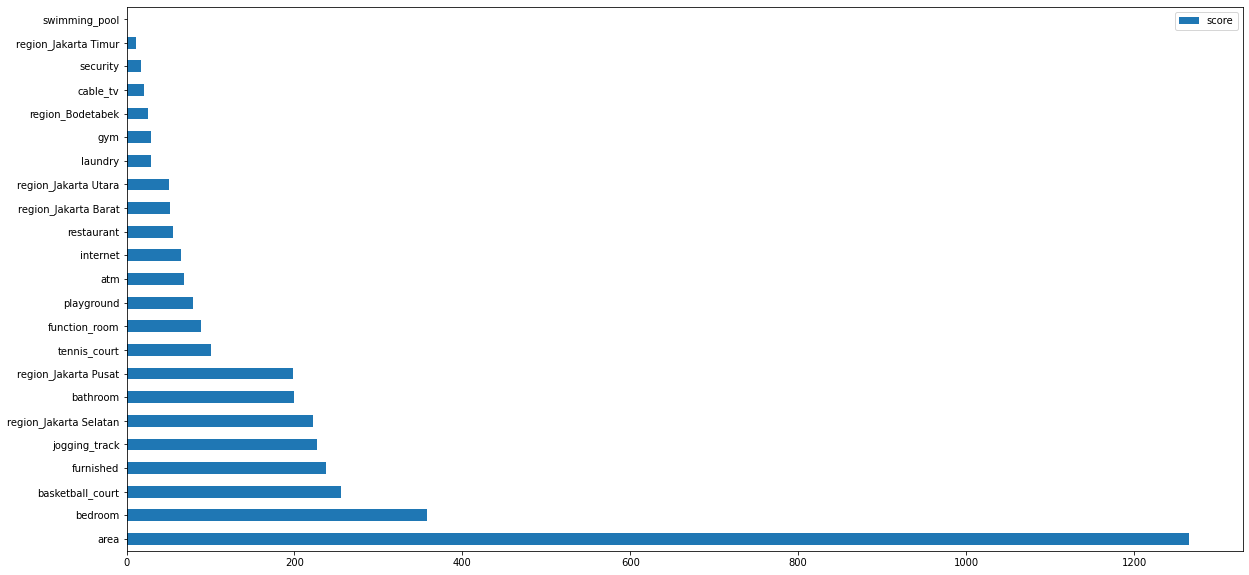

In [20]:
model = XGBRegressor(scale_pos_weight= 13.92, reg_alpha= 0.5499999999999999, n_estimators= 80, min_child_weight= 4, max_depth= 6, learning_rate= 0.05, gamma= 8)
model.fit(X_train,y_train)
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

# Summary

- We choose XGB Model
- Area is the most important thing for annual price